Fintech Project 2: Using Machine Learning to tackle the problem of Credit Card Fraud. 
Credit Card Fraud is a difficult problem to tackle, especially as fraud patterns change over time and are not always easy to spot.
In fact, when using Machine Learning, the problem is also not a straightforward - the datasets require more manipulation as they may not be ordered from the onset.


***Manipulating the dataset***
I am using an online dataset from GitHub. Some of the concepts used here is referenced from the Fraud-Detection-Handbook. I will also employ new models that are not covered by the handbook (i.e. Neural Networks). Note that it is not so easy to find good datasets on Kaggle because most credit card information is classified and protected.

In [3]:
import os
import pandas as pd
import numpy as np
import math
import time
import datetime
import sklearn
from sklearn import *

!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.ipynb

if not os.path.exists("simulated-data-raw"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-raw

def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 83912  100 83912    0     0  83912      0  0:00:01 --:--:--  0:00:01  194k


In [4]:
DIR_INPUT= './simulated-data-raw/data/'
BEGIN_DATE = "2018-04-01"
END_DATE = "2018-09-30"

print("Load files")
transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load files
1754155 transactions loaded, containing 14681 fraudulent transactions


In [5]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


# Feature Engineering

We have successfully imported the raw fradulent data as a pandas dataframe. The raw data contains a number of columns, namely:

1. Transaction ID (ID number of the transaction)
2. Date & Time of Transaction
3. Customer ID
4. Terminal ID
5. Transaction Amount
6. Time(in seconds) of transaction since the first day (i.e. 01/04/2018)
7. Time(in days) of transaction since the first day (i.e. 01/04/2018)
8. Fraud or not? (1 denotes fradulent transactions, whereas 0 denotes genuine transactions)
9. Fraud Scenario (this labels the type of fraud; i.e. as defined by the dataset creators.

As these features are not really useful for our machine learning model (i.e. because they are not numerical and ordered), we have to transform them accordingly. For example, the date is not numerical and neither are the IDs ordered. Thus, we have to transform the data to make it much more useful for our machine learning model. We will do this by being cognisant of the patterns that characterise credit card fraud, discerning the useful features from there. 

3 methods for feature transformation (according to the credit card handbook). 
1. Transforming date/time to binary features (i.e. 1 or 0) that characterise certain periods (weekdays or weekends; day or night).
2. Transforming customer IDs into RFM (Recency, Frequency, Monetary Value) features. For instance, we can denote how frequent the customer IDs make a particular transaction etc. 
3. Transforming the terminal ID into a new feature that highlights the risk associated with the terminal (i.e. whether the terminal is high risk or not based on the amount of fraud that has occured in that terminal)

In [6]:
### Transforming the date and time ###

def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

%time transactions_df['TX_DURING_WEEKEND']=transactions_df.TX_DATETIME.apply(is_weekend)

def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

%time transactions_df['TX_DURING_NIGHT']=transactions_df.TX_DATETIME.apply(is_night)

### Transforming the customer ID into recency frequency monetary value; this gives us the frequency of transaction and the mean amount ####

def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

%time transactions_df=transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

## Essentially, the rolling window implementation just computes the average amount and number of transactions for the past 1day, 7days, 30days with the latest transaction being the transaction that python is currently 'iterating' over.

### Transforming the Terminal ID ### 
### The objective of the transformation here is to obtain a feature that describes the risk associated with the terminal over a particular period (i.e. 1, 7 ,30 days) ##
### To be a closer fit to reality, the model needs to also reflect the 'delay period'. I.E. Fraud can only be detected a certain time after it is committed.
### The way this is modelled is to let the default delay period be 7 days. I.E. We only compute the window of 1,7,30 days after starting from todays date minus 7 days.

def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions


transactions_df[transactions_df.TX_FRAUD==1]
%time transactions_df=transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
transactions_df=transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

transactions_df




Wall time: 5.96 s
Wall time: 6.06 s
Wall time: 34.8 s
Wall time: 1min 25s


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0,1,...,1.0,57.160000,1.0,57.160000,0.0,0.0,0.0,0.0,0.0,0.00000
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0,1,...,1.0,81.510000,1.0,81.510000,0.0,0.0,0.0,0.0,0.0,0.00000
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0,1,...,1.0,146.000000,1.0,146.000000,0.0,0.0,0.0,0.0,0.0,0.00000
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0,1,...,1.0,64.490000,1.0,64.490000,0.0,0.0,0.0,0.0,0.0,0.00000
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0,1,...,1.0,50.990000,1.0,50.990000,0.0,0.0,0.0,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,0,0,1,...,12.0,67.047500,72.0,69.521111,1.0,0.0,4.0,0.0,28.0,0.00000
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,0,0,1,...,21.0,22.173810,93.0,24.780753,1.0,0.0,9.0,0.0,39.0,0.00000
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,0,0,1,...,21.0,7.400476,65.0,7.864462,1.0,0.0,5.0,0.0,33.0,0.00000
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,0,0,1,...,16.0,107.052500,51.0,102.919608,1.0,0.0,6.0,0.0,28.0,0.00000


Splitting the training and test sets

In [7]:

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)


def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7,
                       sampling_ratio=1.0,
                       random_state=0):
    
    # Get the training set data
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Get the test set data
    test_df = []
    
    # Note: Cards known to be frauded after the delay period are removed from the test set
    # That is, for each test day, all frauds known at (test_day-delay_period) are removed
    
    # First, get known frauded customers from the training set
    known_frauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Get the relative starting day of training set (easier than TX_DATETIME to collect test data)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Then, for each day of the test set
    for day in range(delta_test):
    
        # Get test data for that day
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Frauded cards from that test day, minus the delay period, are added to the pool of known frauded customers
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_frauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_frauded_customers = known_frauded_customers.union(new_frauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_frauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # If subsample
    if sampling_ratio<1:
        
        train_df_frauds=train_df[train_df.TX_FRAUD==1].sample(frac=sampling_ratio, random_state=random_state)
        train_df_genuine=train_df[train_df.TX_FRAUD==0].sample(frac=sampling_ratio, random_state=random_state)
        train_df=pd.concat([train_df_frauds,train_df_genuine])
        
    # Sort data sets by ascending order of transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)
                               


### Assume that the training data consists of data for 7 days;
### Assume that the test data consists of data for 7 days
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)



### Using a function that will convert everything to a standard scale - prevents the prediction from becoming out of hand.
### This is applied to the numerical data that all have particular frequencies/ values/ amounts to them.

## --> Please refresh your concepts on preprocessing data 
## --> https://scikit-learn.org/stable/modules/preprocessing.html

def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)



Final preprocessing of data

In [8]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


### Adapt the decision tree model



(train_df,test_df) = scaleData(train_df,test_df,input_features) 

## predict_proba returns array-like of shape (n_samples, n_classes), i.e. probability of the two classes in each column
### Essentially, the predictions just mean: the number of observations of class A (fradulent) that have been
## "captured" by that leaf corresponding to that particular observational row 
## over the entire number of observations captured by that leaf (during training).
## Instead of showing the prediction in a binary-fashion (i.e. fraud or not fraud), we determine the likelihood 
## that a particular transaction will yield fraud; (not too sure of what the 'limits' are). We can use this 
## probability, in combination with a threshold, to classify whether a transaction is fradulent or not. 





***Validation***

In [9]:
# Trying the mean misclassification error (known to be inaccurate because the dataset is extremely unbalanced- 
# - very low amount of fraud compared to genuine transactions)
## What threshold should it be such that you declare it fraud after that particular point?
def misclassification(p_set,dframe):
    new_df = dframe.copy()
    new_df.columns.get_loc("TX_FRAUD")
    new_df.insert(8,"TX_PREDICTED_FRAUD",p_set.tolist())
    new_df["TX_PREDICTED_FRAUD"]=new_df["TX_PREDICTED_FRAUD"].apply(lambda x: 1 if x>0.5 else 0)
    predicted_series = new_df["TX_PREDICTED_FRAUD"]
    actual_series = new_df["TX_FRAUD"]
    comparison = predicted_series.eq(actual_series)
    true_false = comparison.value_counts().to_frame()
    ## From this we can calculate the rate of misclassification
    n_true = true_false.loc[True, 0]
    print("Number of correctly classified is", n_true)
    n_false = true_false.loc[False,0]
    print("Number of wrongly classified is", n_false)
    print("The rate of misclassification is", n_false/n_true,"%")
    return new_df



# Using AUC ROC instead of misclassification

But this is inaccurate in the sense that the how good the model is performing is definitely overrated, given that the dataset is 'imbalanced' - I.E. there is an extremely high amount of genuine credit card transactions as opposed to fradulent ones. Hence, we should try to use other means of evaluating performance which might be less prone to the flaws of the unbalanced dataset. One such metric which could be more reliable is ROC AUC 
<br> <br> Also, because the threshold that each fraud detection system is operating at is different, this ROC AUC metric allows us to evaluate the model over a series of thresholds. 

In [10]:
def threshold_based_metrics(fraud_probabilities, true_label, thresholds_list):

    
    results = []
    
    for threshold in thresholds_list:
    
        predicted_classes = get_class_from_fraud_probability(fraud_probabilities, threshold=threshold)
    
        (TN, FP, FN, TP) = metrics.confusion_matrix(true_label, predicted_classes).ravel()
    
        MME = (FP+FN)/(TN+FP+FN+TP)
    
        TPR = TP/(TP+FN)
        TNR = TN/(TN+FP)
    
        FPR = FP/(TN+FP)
        FNR = FN/(TP+FN)
        
        BER = 1/2*(FPR+FNR)
        
        Gmean = np.sqrt(TPR*TNR)
    
        precision = 0
        FDR = 0
        F1_score=0
        
        if TP+FP>0:
            precision = TP/(TP+FP)
            FDR=FP/(TP+FP)
        
        NPV = 0
        FOR = 0
        
        if TN+FN>0:
            NPV = TN/(TN+FN)
            FOR = FN/(TN+FN)
            
        
        if precision+TPR>0:
            F1_score = 2*(precision*TPR)/(precision+TPR)
    
        results.append([threshold, MME, TPR, TNR, FPR, FNR, BER, Gmean, precision, NPV, FDR, FOR, F1_score])
        
    results_df = pd.DataFrame(results,columns=['Threshold' ,'MME', 'TPR', 'TNR', 'FPR', 'FNR', 'BER', 'G-mean', 'Precision', 'NPV', 'FDR', 'FOR', 'F1 Score'])
    
    return results_df

import matplotlib.pyplot as plt

def get_roc_curve(ax,title,fs,random):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")


def plot_ROC(p_set,title,axis,df,r,c):
    # true labels as list
    true_labels = df["TX_FRAUD"].tolist()
    p_set = list(p_set)
    # fraud probabilities from predict probaility as list
    #print(true_labels)
    #print(fraud_p)

    # threshold gives the threshold for all different thresholds

    FalsePositiveRate, TruePositiveRate, thresholds = sklearn.metrics.roc_curve(true_labels,p_set, drop_intermediate=False) 
    print(thresholds)
    ROC_AUC = metrics.auc(FalsePositiveRate,TruePositiveRate)
    get_roc_curve(axis,"ROC Curve",15,r)
    axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
    axis.legend(loc='lower right')


# Trying the decision tree models (without Ensemble)
<br> We will start with the baseline decision tree model and then we will proceed to tune its hyperparameters
<br> The hyperparameters can be tuned by observing changes in the AUC ROC curve after altering the parameters


# Parameters to alter in the decision tree:
<br> default = "best" or "random" (best evaluates all splits before splitting; random uses a random function to split)
<br> max_depth (controlling underfitting versus overfitting)
<br> min_samples_split (internal nodes: minimum amount of samples)
<br> min_samples_leaf 
<br> min_impurity_decrease (you'd have to plot the tree to determine the Gini values first)
<br> to tackle imbalanced datasets, use min_weight_fraction_leaf; class_weight


[2. 1. 0.]
[2. 1. 0.]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.         1.         0.97356828 0.18965517 0.10752688 0.0625
 0.00305963 0.        ]
[2.         1.         0.97356828 0.33333333 0.18965517 0.10752688
 0.0625     0.00305963 0.        ]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.         1.         0.98564593 0.75       0.14814815 0.08791209
 0.08045977 0.05263158 0.002958   0.        ]
[2.         1.         0.98564593 0.83333333 0.75       0.14814815
 0.08791209 0.08045977 0.05263158 0.002958   0.        ]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.         1.         0.92307692 0.66666667 0.5        0.21052632
 0.11764706 0.07865169 0.05952381 0.05263158 0.04135338 0.00282947
 0.        ]
[2.         1.         0.9375     0.92307692 0.66666667 0.5
 0.21052632 0.11764706 0.07865169 0.05952381 0.05263158 0.04135338
 0.00282947 0.        ]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.47368421e-01 6.66666667e-01
 3.33333333e-01 2.94117647e-01 2.00000000e-01 1.93548387e-01
 4.34782609e-02 3.46153846e-02 1.21951220e-02 4.35787639e-03
 1.81355633e-03 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.47368421e-01 6.66666667e-01
 3.33333333e-01 2.94117647e-01 2.00000000e-01 1.93548387e-01
 4.34782609e-02 3.46153846e-02 1.21951220e-02 4.35787639e-03
 1.81355633e-03 0.00000000e+00]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 8.18181818e-01 8.00000000e-01
 6.00000000e-01 5.00000000e-01 1.50000000e-01 8.69565217e-02
 7.69230769e-02 6.66666667e-02 5.88235294e-02 3.10077519e-02
 6.13496933e-03 3.60339857e-03 1.78913416e-03 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 8.18181818e-01 8.00000000e-01
 6.00000000e-01 5.00000000e-01 1.50000000e-01 8.69565217e-02
 7.69230769e-02 6.66666667e-02 5.88235294e-02 3.10077519e-02
 6.13496933e-03 3.60339857e-03 1.78913416e-03 0.00000000e+00]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.47368421e-01 9.00000000e-01
 8.00000000e-01 3.33333333e-01 2.50000000e-01 8.72483221e-02
 4.54545455e-02 2.47933884e-02 3.25773713e-03 3.12798016e-03
 1.41942403e-03 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.47368421e-01 9.00000000e-01
 8.00000000e-01 3.33333333e-01 2.50000000e-01 1.25000000e-01
 8.72483221e-02 4.54545455e-02 2.47933884e-02 3.25773713e-03
 3.12798016e-03 1.41942403e-03 0.00000000e+00]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.16666667e-01 5.00000000e-01
 2.50000000e-01 1.28205128e-01 2.73972603e-02 2.10084034e-02
 1.45985401e-02 3.13283208e-03 2.94162592e-03 1.35946886e-03
 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.16666667e-01 5.00000000e-01
 2.50000000e-01 1.28205128e-01 2.73972603e-02 2.10084034e-02
 1.45985401e-02 3.13283208e-03 2.94162592e-03 1.35946886e-03
 0.00000000e+00]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


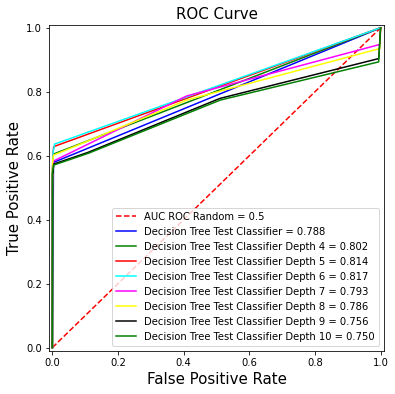

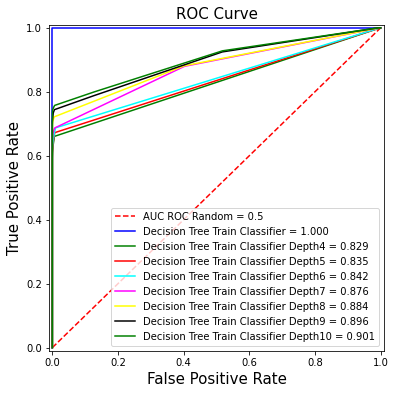

In [11]:
Base_DecisionTree_model = sklearn.tree.DecisionTreeClassifier(random_state=0)
Base_DecisionTree_model.fit(train_df[input_features],train_df[output_feature])
DT_predictions = Base_DecisionTree_model.predict_proba(test_df[input_features])[:,1]
DT_train_predictions = Base_DecisionTree_model.predict_proba(train_df[input_features])[:,1]

test_roc_curve, test_ax = plt.subplots(figsize=(6,6))
train_roc_curve, train_ax = plt.subplots(figsize=(6,6))

plot_ROC(DT_predictions, "Decision Tree Test Classifier", test_ax,test_df,True,'blue')
plot_ROC(DT_train_predictions,"Decision Tree Train Classifier",train_ax,train_df,True,'blue')

## Changing the maximum depth of the trees
def tune_DT_depth(a,b):
    colours = ['green','red','cyan','magenta','yellow','black','green']
    index=0
    for i in range(a,b):
        DT_model_new = sklearn.tree.DecisionTreeClassifier(random_state=0,max_depth=i)
        DT_model_new.fit(train_df[input_features],train_df[output_feature])
        DT_new_train_predictions = DT_model_new.predict_proba(train_df[input_features])[:,1]
        DT_new_test_predictions = DT_model_new.predict_proba(test_df[input_features])[:,1]
        plot_ROC(DT_new_test_predictions, "Decision Tree Test Classifier Depth "+ str(i), test_ax,test_df,False,colours[index])
        plot_ROC(DT_new_train_predictions,"Decision Tree Train Classifier Depth"+ str(i),train_ax,train_df,False,colours[index])
        index+=1
tune_DT_depth(4,11)







# Does this show an effective model? + What is the optimal depth?

Definitely, the model is helpful in that it is better than having an entirely random classifier to detect fraud. This is because from the AUC ROC curve, we can see that the DT classifier has a larger area than the random classifier.
<br> The optimal depth appears to be about 6, anything more than that and we see the area under curve for the test set decreasing but the AUC for the training set increasing. 
<br> A depth of 6 gives an AUC ROC value of about 0.817 for the test set.

# Altering other hyperparameters 
<br> We will try to alter other hyperparameters (instead of depth), to see if we can get a better AUC ROC score compared to 0.817 for the depth of 6.

[2. 1. 0.]
[2. 1. 0.]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.66666667e-01 1.53061224e-01 1.28205128e-01
 8.72483221e-02 8.04597701e-02 7.14285714e-02 6.25000000e-02
 5.88235294e-02 5.26315789e-02 4.34782609e-02 3.92156863e-02
 3.57142857e-02 2.94117647e-02 2.73972603e-02 2.51572327e-02
 2.30769231e-02 2.22222222e-02 2.08333333e-02 1.92307692e-02
 1.61290323e-02 1.56250000e-02 1.49253731e-02 1.27388535e-02
 1.20481928e-02 9.09090909e-03 8.33333333e-03 7.93650794e-03
 7.35294118e-03 7.22543353e-03 7.13194091e-03 7.09219858e-03
 6.99300699e-03 4.86026731e-03 4.38596491e-03 4.13223140e-03
 4.01069519e-03 3.95256917e-03 3.81679389e-03 3.59496705e-03
 3.50262697e-03 3.43642612e-03 3.33055787e-03 2.96033156e-03
 2.73224044e-03 2.60416667e-03 2.59824618e-03 2.43902439e-03
 1.81356547e-03 1.73010381e-03 1.55279503e-03 1.09449106e-03
 6.93481276e-04 3.63240102e-04 3.14169023e-04 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.66666

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.66666667e-01 1.53061224e-01 1.28205128e-01
 8.72483221e-02 8.04597701e-02 7.14285714e-02 6.25000000e-02
 5.88235294e-02 5.26315789e-02 4.34782609e-02 3.92156863e-02
 3.57142857e-02 2.94117647e-02 2.73972603e-02 2.51572327e-02
 2.30769231e-02 2.22222222e-02 2.08333333e-02 1.92307692e-02
 1.61290323e-02 1.56250000e-02 1.49253731e-02 1.27388535e-02
 9.09090909e-03 8.33333333e-03 7.93650794e-03 7.35294118e-03
 7.22543353e-03 7.13194091e-03 7.09219858e-03 6.99300699e-03
 4.38596491e-03 4.01069519e-03 3.95256917e-03 3.81679389e-03
 3.59496705e-03 3.50262697e-03 2.96033156e-03 2.73224044e-03
 2.60416667e-03 2.59824618e-03 2.43902439e-03 1.96408530e-03
 1.81356547e-03 1.26454224e-03 6.93481276e-04 6.07041684e-04
 4.02495472e-04 3.14169023e-04 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.66666667e-01 1.53061224e-01 1.28205128e-01
 8.72483221e-02 8.04597701e-02 7.14285

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 7.14285714e-02 6.25000000e-02 5.88235294e-02
 5.26315789e-02 3.92156863e-02 3.57142857e-02 2.94117647e-02
 2.73972603e-02 2.51572327e-02 1.92307692e-02 1.61290323e-02
 1.49253731e-02 1.27388535e-02 9.09090909e-03 8.33333333e-03
 7.93650794e-03 7.35294118e-03 7.22543353e-03 7.13194091e-03
 7.09219858e-03 6.99300699e-03 4.38596491e-03 3.95256917e-03
 3.59496705e-03 3.50262697e-03 3.24675325e-03 2.96033156e-03
 2.59824618e-03 1.96408530e-03 1.82815356e-03 1.81356547e-03
 1.26454224e-03 4.02495472e-04 3.50201366e-04 1.65261940e-04
 1.64554879e-04 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 7.14285714e-02 6.25000000e-02 5.88235294e-02
 5.26315789e-02 3.92156863e-02 3.57142857e-02 2.94117647e-02
 2.73972603e-02 2.51572327e-02 1.92307692e-02 1.61290

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 6.25000000e-02 5.88235294e-02 5.26315789e-02
 3.92156863e-02 3.57142857e-02 2.94117647e-02 2.73972603e-02
 2.51572327e-02 1.92307692e-02 1.61290323e-02 1.49253731e-02
 1.27388535e-02 9.09090909e-03 7.35294118e-03 7.22543353e-03
 7.09219858e-03 6.99300699e-03 4.38596491e-03 3.95256917e-03
 3.59496705e-03 3.50262697e-03 3.25773713e-03 3.24675325e-03
 2.96033156e-03 2.59824618e-03 1.26454224e-03 1.14573786e-03
 1.05472870e-03 1.65261940e-04 1.64554879e-04 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 6.25000000e-02 5.88235294e-02 5.26315789e-02
 3.92156863e-02 3.57142857e-02 2.94117647e-02 2.73972603e-02
 2.51572327e-02 1.92307692e-02 1.61290323e-02 1.49253731e-02
 1.27388535e-02 9.09090909e-03 7.35294118e-03 7.22543353e-03
 7.09219858e-03 6.99300

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 6.25000000e-02 5.88235294e-02 5.26315789e-02
 3.92156863e-02 3.57142857e-02 2.94117647e-02 2.73972603e-02
 2.51572327e-02 1.92307692e-02 1.61290323e-02 1.49253731e-02
 1.27388535e-02 9.09090909e-03 7.35294118e-03 7.22543353e-03
 7.09219858e-03 6.99300699e-03 4.38596491e-03 3.95256917e-03
 3.59496705e-03 3.50262697e-03 3.25773713e-03 3.24675325e-03
 2.96033156e-03 2.59824618e-03 1.14573786e-03 1.05472870e-03
 5.99700150e-04 1.64554879e-04 0.00000000e+00]
[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 6.25000000e-02 5.88235294e-02 5.26315789e-02
 3.92156863e-02 3.57142857e-02 2.94117647e-02 2.73972603e-02
 2.51572327e-02 1.92307692e-02 1.61290323e-02 1.49253731e-02
 1.27388535e-02 9.09090909e-03 7.35294118e-03 7.22543353e-03
 7.09219858e-03 6.99300699e-03 4.38596

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 6.25000000e-02 5.88235294e-02 5.26315789e-02
 3.92156863e-02 3.57142857e-02 2.94117647e-02 2.73972603e-02
 2.51572327e-02 1.92307692e-02 1.49253731e-02 1.27388535e-02
 9.09090909e-03 7.35294118e-03 7.22543353e-03 7.09219858e-03
 6.99300699e-03 4.38596491e-03 3.95256917e-03 3.59496705e-03
 3.50262697e-03 3.25773713e-03 3.24675325e-03 2.96033156e-03
 1.54188796e-03 7.50638042e-04 5.99700150e-04 1.64554879e-04]
[2.00000000e+00 1.00000000e+00 9.84496124e-01 8.00000000e-01
 6.23342175e-01 1.53061224e-01 1.28205128e-01 8.72483221e-02
 8.04597701e-02 6.25000000e-02 5.88235294e-02 5.26315789e-02
 3.92156863e-02 3.57142857e-02 2.94117647e-02 2.73972603e-02
 2.51572327e-02 1.92307692e-02 1.49253731e-02 1.27388535e-02
 9.09090909e-03 7.35294118e-03 7.22543353e-03 7.09219858e-03
 6.99300699e-03 4.38596491e-03 3.95256917e-03 3.59496705e-03
 3.50262697e-03 3.25773

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, 

[1.9527897  0.9527897  0.94074074 0.21232877 0.1        0.09195402
 0.09027778 0.08888889 0.08148148 0.05454545 0.04278075 0.03703704
 0.03472222 0.02702703 0.02631579 0.025      0.02298851 0.02222222
 0.02205882 0.02197802 0.02189781 0.02173913 0.02150538 0.02030457
 0.02013423 0.01910828 0.01777778 0.01744186 0.01685393 0.01630435
 0.01481481 0.01459854 0.01449275 0.01438849 0.01342282 0.01282051
 0.01242236 0.01229508 0.01190476 0.01075269 0.00970874 0.00884956
 0.00847458 0.00740741 0.00735294 0.0070922  0.00704225 0.00636943
 0.00609756 0.00555556 0.00531915 0.00529101 0.00469484 0.00431034
 0.        ]
[1.9527897  0.9527897  0.94074074 0.21232877 0.1        0.09195402
 0.09027778 0.08888889 0.08148148 0.05454545 0.04278075 0.03703704
 0.03472222 0.02702703 0.02631579 0.025      0.02298851 0.02222222
 0.02205882 0.02197802 0.02189781 0.02173913 0.02150538 0.02030457
 0.02013423 0.01910828 0.01777778 0.01744186 0.01685393 0.01630435
 0.01481481 0.01459854 0.01449275 0.01438849 0.01

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[1.62334218 0.62334218 0.55144033 0.14814815 0.06007067 0.05445545
 0.04511278 0.03296703 0.03292181 0.02469136 0.02181818 0.02057613
 0.01818182 0.01785714 0.01646091 0.01582278 0.0155642  0.01423488
 0.01234568 0.01067616 0.00938967 0.00872093 0.00823045 0.00819672
 0.00816327 0.008      0.00773196 0.00771208 0.00735294 0.00724638
 0.00621118 0.00598802 0.00483092 0.00411523 0.00396825 0.00389105
 0.00387597 0.0033557  0.0025     0.00247525 0.        ]
[1.62334218 0.62334218 0.55144033 0.14814815 0.06007067 0.05445545
 0.04511278 0.03296703 0.03292181 0.02469136 0.02181818 0.02057613
 0.01818182 0.01785714 0.01646091 0.01582278 0.0155642  0.01423488
 0.01234568 0.01067616 0.00938967 0.00872093 0.00823045 0.00819672
 0.00816327 0.008      0.00773196 0.00771208 0.00735294 0.00724638
 0.00621118 0.00598802 0.00483092 0.00411523 0.00396825 0.00389105
 0.00387597 0.0033557  0.0025     0.00247525 0.        ]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[1.62334218 0.62334218 0.39428571 0.10857143 0.05459057 0.04571429
 0.04       0.02571429 0.01971326 0.01542416 0.01428571 0.0124031
 0.012      0.01142857 0.01061008 0.00928793 0.00857143 0.00854701
 0.00848896 0.00823045 0.00822368 0.00813008 0.00728155 0.00723589
 0.00672269 0.00571429 0.00568182 0.0056391  0.00499168 0.00434783
 0.00398406 0.00371058 0.00369004 0.00339559 0.00285714 0.002849
 0.00284091 0.00274725 0.00248139 0.00244499 0.00212766 0.00189753
 0.        ]
[1.62334218 0.62334218 0.39428571 0.10857143 0.05459057 0.04571429
 0.04       0.02571429 0.01971326 0.01542416 0.01428571 0.0124031
 0.012      0.01142857 0.01061008 0.00928793 0.00857143 0.00854701
 0.00848896 0.00823045 0.00822368 0.00813008 0.00728155 0.00723589
 0.00672269 0.00571429 0.00568182 0.0056391  0.00499168 0.00434783
 0.00398406 0.00371058 0.00369004 0.00339559 0.00285714 0.002849
 0.00284091 0.00274725 0.00248139 0.00244499 0.00212766 0.00189753
 0.        ]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[1.51666667e+00 5.16666667e-01 3.01310044e-01 8.26771654e-02
 3.49344978e-02 3.27510917e-02 1.80722892e-02 1.74672489e-02
 1.58415842e-02 1.31004367e-02 1.28205128e-02 1.09170306e-02
 9.16230366e-03 8.73362445e-03 8.54700855e-03 7.25689405e-03
 7.20720721e-03 6.63349917e-03 6.55021834e-03 6.22406639e-03
 6.07902736e-03 5.24246396e-03 4.45765230e-03 4.36681223e-03
 4.26136364e-03 4.23131171e-03 3.86100386e-03 3.74531835e-03
 3.67647059e-03 3.52112676e-03 3.29308452e-03 2.43902439e-03
 2.18340611e-03 2.14132762e-03 2.07900208e-03 2.05338809e-03
 1.62601626e-03 1.43061516e-03 1.10864745e-03 0.00000000e+00]
[1.51666667e+00 5.16666667e-01 3.01310044e-01 8.26771654e-02
 3.49344978e-02 3.27510917e-02 1.80722892e-02 1.74672489e-02
 1.58415842e-02 1.31004367e-02 1.28205128e-02 1.09170306e-02
 9.16230366e-03 8.73362445e-03 8.54700855e-03 7.25689405e-03
 7.20720721e-03 6.63349917e-03 6.55021834e-03 6.22406639e-03
 6.07902736e-03 5.24246396e-03 4.45765230e-03 4.36681223e-03
 4.26136364e-03 4.23131

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[1.41311475e+00 4.13114754e-01 2.44247788e-01 7.43362832e-02
 2.83185841e-02 2.55536627e-02 1.71428571e-02 1.45867099e-02
 1.23915737e-02 1.03926097e-02 8.54700855e-03 8.51063830e-03
 7.93650794e-03 7.25689405e-03 7.06713781e-03 6.84931507e-03
 6.63349917e-03 6.25000000e-03 6.04594921e-03 5.97907324e-03
 5.84795322e-03 5.18134715e-03 4.43786982e-03 4.41826215e-03
 4.36046512e-03 3.57462020e-03 3.53982301e-03 3.35570470e-03
 3.26797386e-03 3.08641975e-03 2.90697674e-03 2.72108844e-03
 1.76991150e-03 1.63666121e-03 1.08108108e-03 1.06269926e-03
 9.37207123e-04 0.00000000e+00]
[1.41311475e+00 4.13114754e-01 2.44247788e-01 7.43362832e-02
 2.83185841e-02 2.55536627e-02 1.71428571e-02 1.45867099e-02
 1.23915737e-02 1.03926097e-02 8.54700855e-03 8.51063830e-03
 7.93650794e-03 7.25689405e-03 7.06713781e-03 6.84931507e-03
 6.63349917e-03 6.25000000e-03 6.04594921e-03 5.97907324e-03
 5.84795322e-03 5.18134715e-03 4.43786982e-03 4.41826215e-03
 4.36046512e-03 3.57462020e-03 3.53982301e-03 3.35570

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


[1.33077905e+00 3.30779055e-01 2.04747774e-01 6.24071322e-02
 2.37741456e-02 2.22882615e-02 1.29589633e-02 1.24378109e-02
 1.10192837e-02 8.91530461e-03 7.32064422e-03 7.23589001e-03
 7.21500722e-03 6.94444444e-03 6.83371298e-03 6.09756098e-03
 5.94353640e-03 5.84112150e-03 4.73559590e-03 4.45765230e-03
 4.36046512e-03 4.23370025e-03 3.54609929e-03 3.39558574e-03
 2.91545190e-03 2.90275762e-03 2.87356322e-03 2.84900285e-03
 2.34558249e-03 2.20994475e-03 1.93986421e-03 1.82149362e-03
 1.52905199e-03 1.48588410e-03 1.36612022e-03 1.27064803e-03
 8.61326443e-04 0.00000000e+00]
[1.33077905e+00 3.30779055e-01 2.04747774e-01 6.24071322e-02
 2.37741456e-02 2.22882615e-02 1.29589633e-02 1.24378109e-02
 1.10192837e-02 8.91530461e-03 7.32064422e-03 7.23589001e-03
 7.21500722e-03 6.94444444e-03 6.83371298e-03 6.09756098e-03
 5.94353640e-03 5.84112150e-03 4.73559590e-03 4.45765230e-03
 4.36046512e-03 4.23370025e-03 3.54609929e-03 3.39558574e-03
 2.91545190e-03 2.90275762e-03 2.87356322e-03 2.84900

C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


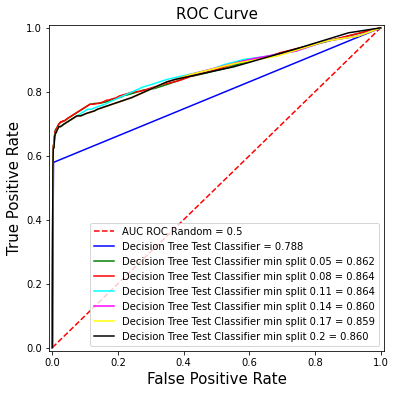

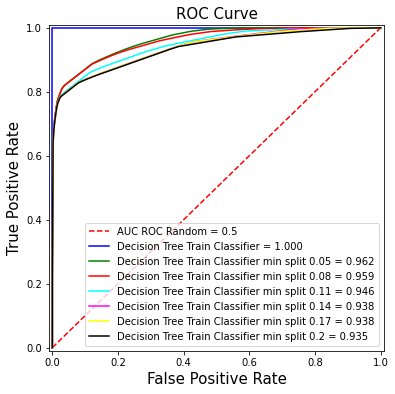

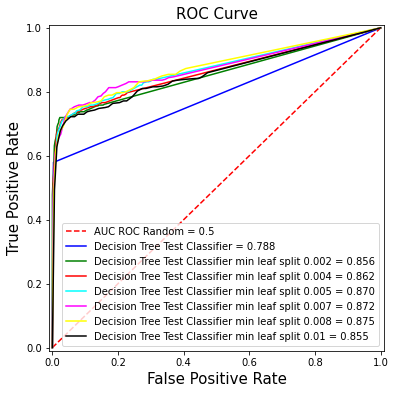

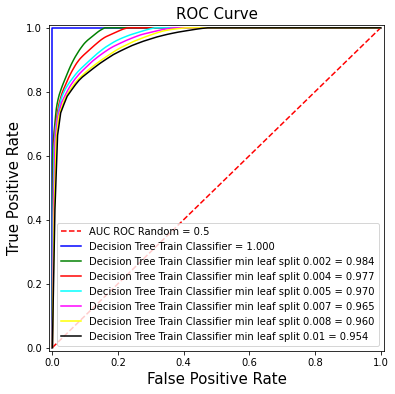

In [12]:
## Changing the maximum depth of the trees
import numpy as np

def tune_DT_split(a,b):
    new_test_roc_curve, new_test_ax = plt.subplots(figsize=(6,6))
    new_train_roc_curve, new_train_ax = plt.subplots(figsize=(6,6))
    plot_ROC(DT_predictions, "Decision Tree Test Classifier", new_test_ax,test_df,True,'blue')
    plot_ROC(DT_train_predictions,"Decision Tree Train Classifier",new_train_ax,train_df,True,'blue')

    colours = ['green','red','cyan','magenta','yellow','black']
    index=0
    num_set = np.linspace(a,b,6)
    for i in num_set:
        DT_model_new = sklearn.tree.DecisionTreeClassifier(random_state=0,min_samples_split=i)
        DT_model_new.fit(train_df[input_features],train_df[output_feature])
        DT_new_train_predictions = DT_model_new.predict_proba(train_df[input_features])[:,1]
        DT_new_test_predictions = DT_model_new.predict_proba(test_df[input_features])[:,1]
        plot_ROC(DT_new_test_predictions, "Decision Tree Test Classifier min split "+ str(round(i,ndigits=2)), new_test_ax,test_df,False,colours[index])
        plot_ROC(DT_new_train_predictions,"Decision Tree Train Classifier min split "+ str(round(i,ndigits=2)),new_train_ax,train_df,False,colours[index])
        index+=1
tune_DT_split(0.05,0.2)

def tune_DT_leaf_split(a,b):
    new_test_roc_curve, new_test_ax = plt.subplots(figsize=(6,6))
    new_train_roc_curve, new_train_ax = plt.subplots(figsize=(6,6))
    plot_ROC(DT_predictions, "Decision Tree Test Classifier", new_test_ax,test_df,True,'blue')
    plot_ROC(DT_train_predictions,"Decision Tree Train Classifier",new_train_ax,train_df,True,'blue')

    colours = ['green','red','cyan','magenta','yellow','black']
    index=0
    num_set = np.linspace(a,b,6)
    for i in num_set:
        DT_model_new = sklearn.tree.DecisionTreeClassifier(random_state=0,min_samples_leaf=i)
        DT_model_new.fit(train_df[input_features],train_df[output_feature])
        DT_new_train_predictions = DT_model_new.predict_proba(train_df[input_features])[:,1]
        DT_new_test_predictions = DT_model_new.predict_proba(test_df[input_features])[:,1]
        plot_ROC(DT_new_test_predictions, "Decision Tree Test Classifier min leaf split "+ str(round(i,ndigits=3)), new_test_ax,test_df,False,colours[index])
        plot_ROC(DT_new_train_predictions,"Decision Tree Train Classifier min leaf split "+ str(round(i,ndigits=3)),new_train_ax,train_df,False,colours[index])
        index+=1
tune_DT_leaf_split(0.002,0.01)

# Consolidating the AUC ROC scores of decision Tree Models with tuned hyper parameters:
<br> Max depth = 6 gives AUC ROC of 0.817
<br> Min samples split (for internal node) = 0.11 gives AUC ROC of 0.864
<br> Min samples leaf = 0.008 gives AUC ROC of 0.875
<br> Thus, the hyperparameter which gives us the best result is a min leaf split of 0.008. It seems much more specific than max depth and min split (for internal node), and thus is advantages in that regard. 

# Usage of Random Forests Classifier

[1.99 0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88 0.87
 0.86 0.85 0.84 0.83 0.82 0.81 0.8  0.79 0.78 0.77 0.76 0.75 0.72 0.7
 0.68 0.67 0.66 0.65 0.64 0.63 0.62 0.6  0.59 0.58 0.57 0.56 0.55 0.54
 0.53 0.52 0.51 0.5  0.49 0.46 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36
 0.35 0.34 0.33 0.32 0.31 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22
 0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08
 0.07 0.06 0.05 0.04 0.03 0.02 0.01 0.  ]
[2.   1.   0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88
 0.87 0.86 0.85 0.84 0.83 0.82 0.81 0.8  0.79 0.78 0.77 0.76 0.75 0.74
 0.73 0.72 0.71 0.7  0.69 0.68 0.67 0.66 0.65 0.64 0.63 0.62 0.61 0.6
 0.59 0.58 0.57 0.56 0.55 0.52 0.49 0.48 0.41 0.38 0.33 0.32 0.31 0.3
 0.26 0.24 0.22 0.21 0.2  0.19 0.18 0.17 0.16 0.15 0.14 0.13 0.12 0.11
 0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03 0.02 0.01 0.  ]


C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )
C:\Users\65932\AppData\Local\Temp/ipykernel_6560/3771715536.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axis.plot(FalsePositiveRate,TruePositiveRate,'b',color=c, label = title + " = " + "{0:0.3f}".format(ROC_AUC) )


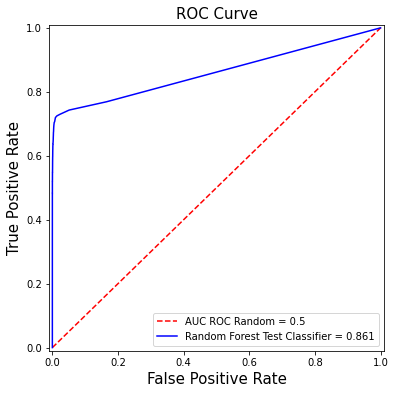

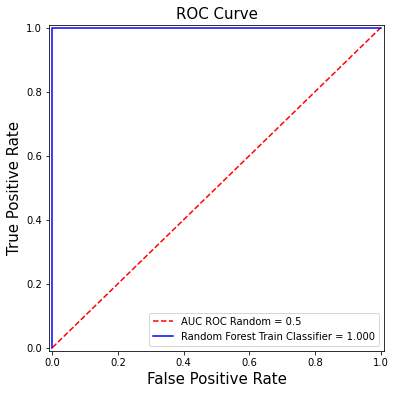

In [13]:
from sklearn.ensemble import RandomForestClassifier

Base_RandomForest = RandomForestClassifier(n_estimators=100)
Base_RandomForest.fit(train_df[input_features],train_df[output_feature])
Base_RandomForest_train_predictions = Base_RandomForest.predict_proba(train_df[input_features])[:,1]
Base_RandomForest_test_predictions = Base_RandomForest.predict_proba(test_df[input_features])[:,1]
RF_test_roc_curve, RF_test_ax = plt.subplots(figsize=(6,6))
RF_train_roc_curve, RF_train_ax = plt.subplots(figsize=(6,6))
plot_ROC(Base_RandomForest_test_predictions, "Random Forest Test Classifier", RF_test_ax,test_df,True,'blue')
plot_ROC(Base_RandomForest_train_predictions,"Random Forest Train Classifier",RF_train_ax,train_df,True,'blue')



# We will also attempt to tune the hyperparameters of random forests, just like how we did for decision trees, but this time using cross validation (RandomisedSearchCV etc.)
We will alter the following parameters:
1) N_estimators
2) Max_depth
3) Min samples split
4) Min samples leaf

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Create a search grid of parameters that will be shuffled through

param_grid = {"max_depth": [10,12,14], "min_samples_leaf": [0.02, 0.05, 0.06], 
"min_samples_split": [0.003,0.004,0.005], "n_estimators": [300, 400, 500]}

# Using the random grid and searching for best hyperparameters

rf = RandomForestClassifier() #creating base model

cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=2,random_state=1)

rf_random = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1,scoring='roc_auc')

rf_random.fit(train_df[input_features], train_df[output_feature]) #fit is to initiate training process

rf_random.best_params_
rf_random.best_score_

C:\Users\65932\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 6 folds for each of 81 candidates, totalling 486 fits


0.8760073283647611

In [23]:
print(rf_random.best_params_)
print(rf_random.best_score_)
print(rf_random.best_estimator_)

{'n_estimators': 400, 'min_samples_split': 0.003, 'min_samples_leaf': 0.02, 'max_depth': 10}
0.8760073283647611
RandomForestClassifier(max_depth=10, min_samples_leaf=0.02,
                       min_samples_split=0.003, n_estimators=400)


# The random forest classifier is likely more robust than the decision tree classifier
<br> The decision tree classifier is only tuned on 1 set of training & test data 
<br> On the other hand, the random forest classfier is tuned on 6 different sets of training & test data
<br> Essentially, this means that the variance for the random forest classifier hyperparameters is lower - that is, the hyperparameters are likely more generalised or more accurate for a wider range of models. The decision tree classifier on the other hand has its hyperparameters more tuned for that particular training & test data set. 
<br> The random forest model shows better performance than the decision tree model, in terms of AUC ROC score on the dataset used to tune the respective models

# Therefore, we will use the random forest classifier with the above stated best hyperparameters(i.e. rf_random.best_estimator_) for credit card fraud detection 